In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('path to local MGWR repository copy')

import gstools as gs


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import seaborn as sns


In [2]:
x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)
#第一个数据

model = gs.Gaussian(dim=2, var=1,len_scale=3.01)
srf = gs.SRF(model,mean=0.)
srf((x, y), mesh_type='structured')
B0=srf((x, y), mesh_type='structured',seed=100)

In [3]:
#运行1000次
# 将数据转换为适合随机森林模型的格式
X = np.column_stack([XX.ravel(), YY.ravel()])
y = B0.ravel()

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林模型
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
def process_data_with_randomness(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    y_pred_full = rf.predict(X).reshape(XX.shape)

    noise=np.random.laplace(0.1,0.02, y_pred_full.shape)+  np.random.poisson(0.05,y_pred_full.shape)+np.random.normal(0.1, 0.02, y_pred_full.shape)
    y_pred_full_with_noise = y_pred_full + noise
    y_pred_full_with_noise_column = y_pred_full_with_noise.ravel()
    return y_pred_full_with_noise_column



def calcuCirculation_for_point(X_train, X_test, y_train, y_test, time):
    all_processed_values = []
    results_df = pd.DataFrame()

    if time != 2:
        for i in range(1, time):
            print(i)
            processed_value = process_data_with_randomness(X_train, X_test, y_train, y_test)
            all_processed_values.append(pd.Series(processed_value, name=f'Out{i}'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("repro-out/pred_nonoisy.csv", index=False)
        # 检查结果
        print(results_df)

times = 1001
# calcuCirculation_for_point(X_train, X_test, y_train, y_test, 2)
calcuCirculation_for_point(X_train, X_test, y_train, y_test, times)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import combinations

import warnings 

warnings.filterwarnings("ignore")

df =data_df= pd.read_csv("./repro-out/pred_nonoisy.csv")
out0 =  pd.read_csv("./../no-noisy/initial-out/pred_nonoisy_initial.csv")
# df["Out0"]=out0
x= df.index


In [5]:

def calculate_proportion(values, lower_bound, upper_bound):
    # 确保所有输入都是 NumPy 数组
    if isinstance(values, pd.Series):
        values = values.to_numpy().flatten()
    if isinstance(lower_bound, pd.Series):
        lower_bound = lower_bound.to_numpy().flatten()
    if isinstance(upper_bound, pd.Series):
        upper_bound = upper_bound.to_numpy().flatten()
    
    common_count = 0
    total_count = len(values)
    
    for value, lb, ub in zip(values, lower_bound, upper_bound):
        # print(value, lb, ub)
        if lb <= value <= ub:
            common_count += 1
            
    return common_count / total_count*100


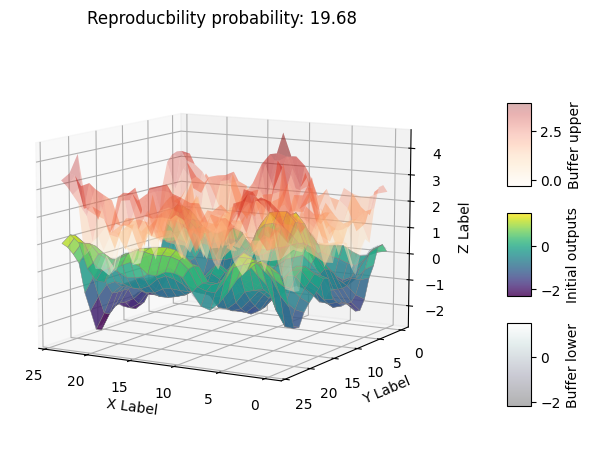

In [6]:
# 初始化缓冲区上下界的数组
buffer_upper = []
buffer_lower = []

# 获取列的范围
start_col = data_df.columns.get_loc("Out1")
end_col = data_df.columns.get_loc(f"Out{times-1}")+1

# 对每一行进行正态性检验并计算缓冲区
for i in range(data_df.shape[0]):
    # row_data = data_df.iloc[i, start_col:end_col]    
    row_data = data_df.iloc[i, start_col:end_col]    
    buffer_upper.append(max(row_data))
    buffer_lower.append(min(row_data))

# 将缓冲区上下界转换为数组
buffer_upper = np.array(buffer_upper)
buffer_lower = np.array(buffer_lower)

probability_within_buffer = calculate_proportion(out0.values,buffer_lower,buffer_upper)



# 初始化 predictions 为字典
array = out0.values
predictions = {'Shape_Out_0': array.reshape(25, 25)}

# 绘制三维图
fig = plt.figure(figsize=(12, 5.5))
ax = fig.add_subplot(111, projection='3d')

# 假设我们绘制 predictions 中的第一个 reshaped 数组
X, Y = np.meshgrid(np.arange(25), np.arange(25))
Z = predictions['Shape_Out_0']

# 确保缓冲区与 reshaped 数据形状一致
buffer_upper_reshape = buffer_upper.reshape(25, 25)
buffer_lower_reshape = buffer_lower.reshape(25, 25)

# 绘制曲面
surf = ax.plot_surface(X, Y, Z, cmap='viridis',color="grey", alpha=0.8, linewidth=0.3)

# 绘制缓冲区上下界，增加透明度使其更明显
lower_surf = ax.plot_surface(X, Y, buffer_lower_reshape, cmap='bone', alpha=0.3, linewidth=0.2)
upper_surf = ax.plot_surface(X, Y, buffer_upper_reshape, cmap='OrRd', alpha=0.3, linewidth=0.2)

# 增加垂直线以更明显显示波动范围
# for i in range(25):
#     for j in range(25):
#         ax.plot([X[i, j], X[i, j]], [Y[i, j], Y[i, j]], [buffer_lower_reshape[i, j], buffer_upper_reshape[i, j]], color='k', alpha=0.5)

# 调整视角
ax.view_init(elev=10, azim=120)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title(f'Reproducbility probability: {probability_within_buffer}')
# 创建独立的颜色条轴并调整位置
fig.subplots_adjust(right=0.9)
cbar_ax1 = fig.add_axes([0.75, 0.6, 0.02, 0.15])
cbar_ax2 = fig.add_axes([0.75, 0.4, 0.02, 0.15])
cbar_ax3 = fig.add_axes([0.75, 0.2, 0.02, 0.15])

cbar1 = fig.colorbar(surf, cax=cbar_ax2)
cbar1.set_label('Initial outputs')
cbar2 = fig.colorbar(upper_surf, cax=cbar_ax1)
cbar2.set_label('Buffer upper')
cbar3 = fig.colorbar(lower_surf, cax=cbar_ax3)
cbar3.set_label('Buffer lower')

plt.show()

原始结果与复现结果之间的ResidualError 95%置信区间: (0.0913, 0.1440);随机误差范围: (0.0777, 0.1321)
总误差覆盖随机-置信区间覆盖率: 0.0449；概率0.8099
随机覆盖总-置信区间覆盖率: 0.7504；概率0.8099
原始结果与复现结果之间的MAE 95%置信区间: (0.2331, 0.2681);随机误差范围: (0.1178, 0.1623)
总误差覆盖随机-置信区间覆盖率: 0.0000；概率0.0
随机覆盖总-置信区间覆盖率: 0.0000；概率0.0
原始结果与复现结果之间的RMSE 95%置信区间: (0.3022, 0.3794);随机误差范围: (0.2789, 0.3635)
总误差覆盖随机-置信区间覆盖率: 0.0879；概率0.8038
随机覆盖总-置信区间覆盖率: 0.7245；概率0.8038


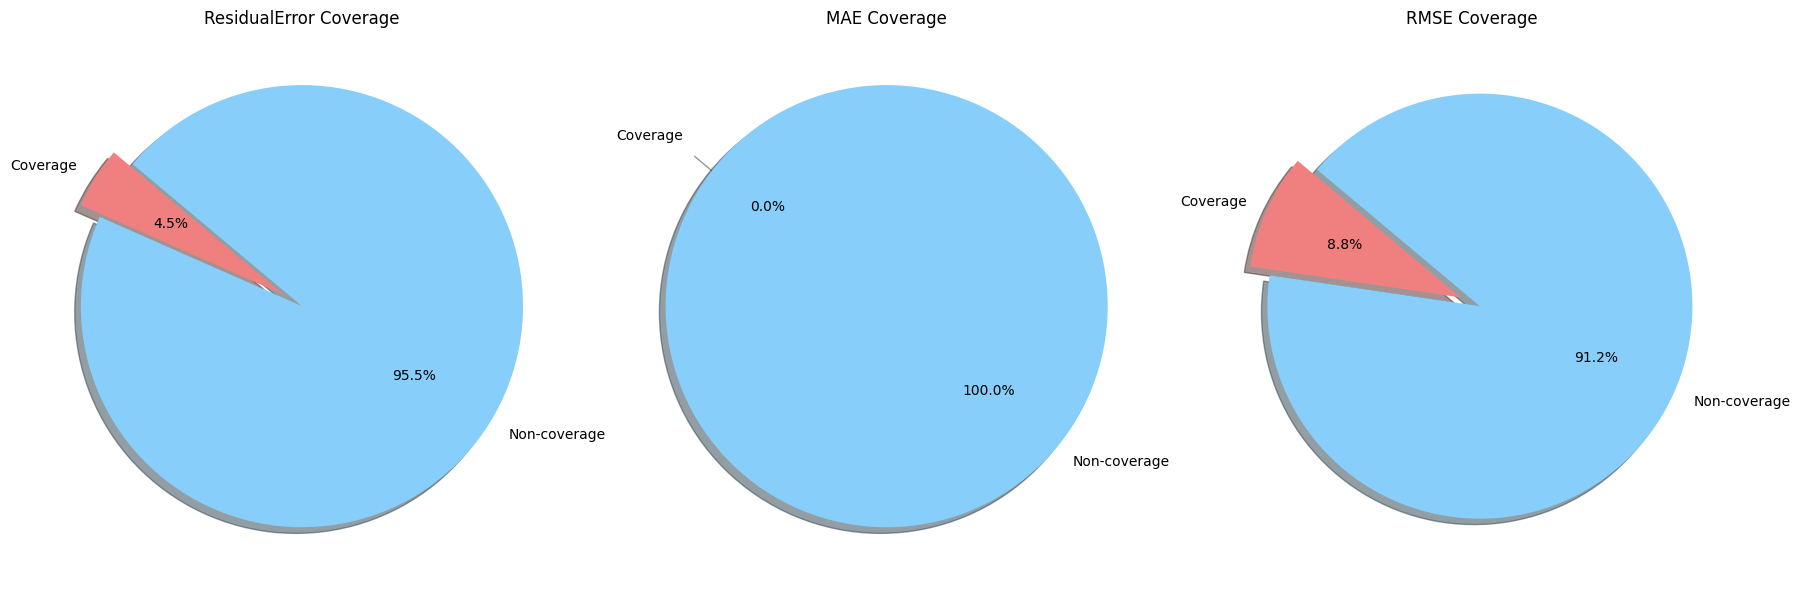

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def calculate_coverage(interval1, interval2):
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap, U_overlap = max(L1, L2), min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1, length2 = U1 - L1, U2 - L2
    coverage = overlap_length / length1
    return coverage 

def calculate_coverage2(interval1, interval2):
    # interval1 总误差
    # interval2 随机误差
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap, U_overlap = max(L1, L2), min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1, length2 = U1 - L1, U2 - L2
    coverage = overlap_length / length2
    return coverage 

def calculate_statistics(data):
    return np.mean(data), np.var(data), np.std(data)

def calculate_confidence_interval(values, alpha=0.05):
    
    values = np.sort(values)
    lower_bound = np.percentile(values, alpha / 2 * 100)
    upper_bound = np.percentile(values, (1 - alpha / 2) * 100)
    return lower_bound, upper_bound

def calculate_proportion(values, lower_bound, upper_bound):
    values = np.asarray(values).flatten()
    
    common_count = 0
    total_count = len(values)
    for value in values:
        if lower_bound <= value <= upper_bound:
            common_count += 1
            
    return common_count / total_count

def lins_ccc(x, y):
    mean_x, mean_y = np.mean(x), np.mean(y)
    var_x, var_y = np.var(x), np.var(y)
    cov_xy = np.mean((x - mean_x) * (y - mean_y))
    rho = cov_xy / np.sqrt(var_x * var_y)
    return (2 * rho * np.sqrt(var_x) * np.sqrt(var_y)) / (var_x + var_y + (mean_x - mean_y)**2)


def calculate_statistic_values(stat_type,outx,outy):
    if stat_type == "R2":
        return r2_score(outx, outy)
    if stat_type == "Lin's CCC":
        return lins_ccc(outx, outy)
    if stat_type=="MAE":
        return mean_absolute_error(outx, outy)
    if stat_type=="MAEP": 
        return np.mean(np.abs((outx - outy) / outx)) * 100
    if stat_type=="RMSE":
        return np.sqrt(mean_squared_error(outx, outy))
    if stat_type=="R2":
        return r2_score(outx, outy)
    if stat_type=="SSE":
        return np.sum((outx - outy) ** 2)
    if stat_type=="ResidualError":

        return np.mean((outx - outy)**2)
    if stat_type=="ResidualError2":
        return np.mean((outx - outy))



def monteCarloMethod(num_samples, data, stat_type):
    monteCarlo_values = []
    sampled_combinations = [np.random.choice(data.columns, 2, replace=False) for _ in range(num_samples)]
    for i, j in sampled_combinations:  
        monteCarlo_values.append(calculate_statistic_values(stat_type,data[i], data[j]))
    return monteCarlo_values

stat_types = ["ResidualError","MAE","RMSE"]

# 创建一个3x1的子图布局
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, stat_type in enumerate(stat_types):
    real_values = [ calculate_statistic_values(stat_type, out0.values.flatten(), data_df[f'Out{i}'].values.flatten()) for i in range(1, 1001)]
    # 计算置信区间-----总误差
    ci_low, ci_high = calculate_confidence_interval(real_values)
    # -----随机误差
    monteCarlo_values = monteCarloMethod(10000, data_df, stat_type)


    ci_low_mc_random, ci_high_mc_random = calculate_confidence_interval(monteCarlo_values)
    print(f"原始结果与复现结果之间的{stat_type} 95%置信区间: ({ci_low:.4f}, {ci_high:.4f});随机误差范围: ({ci_low_mc_random:.4f}, {ci_high_mc_random:.4f})")
    # 计算覆盖率
    ratio_original = calculate_proportion(monteCarlo_values, ci_low, 1)
    coverage = calculate_coverage((ci_low, 1), (ci_low_mc_random, ci_high_mc_random))
    coverage2 = calculate_coverage2((ci_low, 1), (ci_low_mc_random, ci_high_mc_random))
    print(f"总误差覆盖随机-置信区间覆盖率: {coverage:.4f}；概率{ratio_original}")
    print(f"随机覆盖总-置信区间覆盖率: {coverage2:.4f}；概率{ratio_original}")

    # 绘制覆盖率的饼图
    labels = ['Coverage', 'Non-coverage']
    sizes = [coverage, 1-coverage]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # 突出显示覆盖率
    axs[idx].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                 shadow=True, startangle=140)
    axs[idx].axis('equal')
    axs[idx].set_title(f'{stat_type} Coverage')

plt.tight_layout()
plt.show()





In [16]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
## --Prediction--
# 定义计算指标的函数
def calculate_metrics(true_values, predictions, p):
    mae = mean_absolute_error(true_values, predictions)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)
    n = len(true_values)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    sse = np.sum((true_values - predictions) ** 2)
    aic = n * np.log(sse / n) + 2 * (p)
    residual= true_values-predictions

    return mae, mape, rmse, r2, adj_r2, aic,residual.values[0]

p = 7  # 根据你的模型的自变量数量调整
# print(out0.values, data_df['Out1'])
metrics = calculate_metrics(out0.values.flatten(), data_df['Out18'], p)


# 输出结果
print(f"MAE:{round(metrics[0],4)}")
print(f"MAPE:{round(metrics[1],4)}")
print(f"RMSE:{round(metrics[2],4)}")
print(f"R2:{round(metrics[3],4)}")
# print(f"Metrics: Adj.R2:{round(metrics[4],4)}")
# print(f"Metrics: AIC:{round(metrics[5],4)}")
print(f"Residual:{round(metrics[6],4)}")


MAE:0.2483
MAPE:107.7334
RMSE:0.337
R2:0.8178
Residual:-0.2737
